# This code calculates the ground state of $H_2$ molecule
# First, calculate the propagators and save the results.
# Next, use the saved propagators to simulate the quantum circuit.

In [31]:
import numpy as np
import math
import pickle
from qutip import*
import matplotlib.pyplot as plt
import itertools as it
from qutip.qip.circuit import Gate
from qutip.qip.circuit import QubitCircuit, Gate
from qutip import tensor, basis
import time

sqrt = np.sqrt
pi   = np.pi
cos  = np.cos
sin  = np.sin
exp  = np.exp

dissipation = [(30*1e-6), (30*1e-6)]  # in seconds
dephasing =   [(45*1e-6), (45*1e-6)]  # in seconds
ZZ_interaction = 2*pi*100e3         # in kHz
non_linearity  = -2*pi*200e6          # in MHz


gate_time_Paulis = 2.00e-8
gate_time_CZ     = 2.71e-7


Nlevels= 3
A1 = destroy(Nlevels)
HPX = (A1 + A1.dag())/2
HPY = (1j*A1 - 1j*A1.dag())/2
Hamiltonian = non_linearity*A1.dag()*A1.dag()*A1*A1


c_ops = [sqrt(1/dissipation[0])*A1]
c_ops.append(sqrt(1/dephasing[0])*A1.dag()*A1)
c_ops.append(sqrt(ZZ_interaction)*A1.dag()*A1)


start = time.time()

##################################################### PAULI X PROPAGATORS WITH DRAG

B= pi/gate_time_Paulis
def HPx_coeff(t, args):
    if t<=gate_time_Paulis:
        return (2*B*sin(B*t)*sin(B*t))
    
    elif t>=gate_time_Paulis and t<= 2*gate_time_Paulis:
        return (2*B*sin(B*t)*sin(B*t))
    
    else:
        return 0

    
def HPx_derivative(t, args):
    if t<=gate_time_Paulis:
        return ((2*B*B*sin(B*t)*cos(B*t))/(2*non_linearity))
    
    elif t>=gate_time_Paulis and t<=2*gate_time_Paulis:
        return ((2*B*B*sin(B*t)*cos(B*t))/(2*non_linearity))
    
    else:
        return 0    
    
H = [Hamiltonian , [HPX, HPx_coeff] , [HPY, HPx_derivative]]
t = np.linspace(0, gate_time_CZ, 10000)


E_ops = [basis(3,0)*basis(3,0).dag() , basis(3,1)*basis(3,1).dag() , basis(3,2)*basis(3,2).dag()] 
resD = mesolve(H, basis(3,0), t, c_ops=[], e_ops = E_ops)

# plt.plot(t, resD.expect[0])
# plt.plot(t, resD.expect[1])
# plt.plot(t, resD.expect[2], '--')
# plt.ylim([0,1])
# plt.grid('on')

PX_propagators = propagator(H, t, c_op_list=c_ops)

with open('Data\Time', 'wb') as ID:
    pickle.dump(t, ID)
    
with open('Data\PauliX', 'wb') as PX:
    pickle.dump(PX_propagators, PX)

    
    
##################################################### PAULI Y PROPAGATORS WITH DRAG

B= pi/gate_time_Paulis
def HPx_coeff(t, args):
    if t<=gate_time_Paulis:
        return (2*B*sin(B*t)*sin(B*t))
    
    elif t>=gate_time_Paulis and t<=2*gate_time_Paulis:
        return (2*B*sin(B*t)*sin(B*t))
    
    else:
        return 0
    
    
def HPx_derivative(t, args):
    if t<=gate_time_Paulis:
        return ((-2*B*B*sin(B*t)*cos(B*t))/(2*non_linearity))
    
    elif t>=gate_time_Paulis and t<=2*gate_time_Paulis:
        return ((-2*B*B*sin(B*t)*cos(B*t))/(2*non_linearity))
        
    else:
        return 0    
    
H = [Hamiltonian , [HPY, HPx_coeff] , [HPX, HPx_derivative]]

# E_ops = [basis(3,0)*basis(3,0).dag() , basis(3,1)*basis(3,1).dag() , basis(3,2)*basis(3,2).dag()]
# resD = mesolve(H, basis(3,0), t, c_ops=[], e_ops = E_ops)
# plt.plot(t, resD.expect[0])
# plt.plot(t, resD.expect[1])
# plt.plot(t, resD.expect[2], '--')
# plt.ylim([0,1])
# plt.grid('on')

PY_propagators = propagator(H, t, c_op_list=c_ops)

with open('Data\PauliY', 'wb') as PY:
    pickle.dump(PY_propagators, PY)
    
    
    
    
    
##################################################### ANGLE FOR PAULI OPERATORS
angle=[]
for i in t:
    if i<=2*gate_time_Paulis:
        angle.append((B*i) - 0.5*sin(2*B*i))
    else:
        angle.append(2*pi)

# plt.plot(t, angle)
# plt.grid('on')

angle = np.array(angle)

with open('Data\Angle', 'wb') as ID:
    pickle.dump(angle, ID)    
    
    

    
##################################################### HADAMARD GATE
# THIS IS APPLIED BY A PAULI Y GATE AT PI/2 FOLLOWED BY VIRTUAL Z GATE

ewa = angle-pi/2
Index = np.where(np.min(np.abs(ewa)) == ewa)[0][0]
PY_half_pi = PY_propagators[Index]


# Virtual Z gate with angle pi
Z = np.zeros((3,3))
Z[0,0] = 1
Z[1,1] = -1
Z[2,2] = 1
Z = to_super(Qobj(Z))

HD_propagator = Z*PY_half_pi

#qc = QubitCircuit(N=1)
#qc.add_gate("RY", targets=0 , arg_value = pi/2)
#qc.add_gate("RZ", targets=0 , arg_value = pi)
#1j*qc.propagators()[0] * qc.propagators()[1] * basis(2,0)

with open('Data\Hadamard', 'wb') as ID:
    pickle.dump(HD_propagator, ID)
    
    
    

##################################################### IDLE GATE
H = non_linearity*A1.dag()*A1.dag()*A1*A1 
Idle_propagator = propagator(H, t, c_op_list=c_ops)
  
with open('Data\Idle', 'wb') as ID:
    pickle.dump(Idle_propagator, ID)
    
    

##################################################### CZ GATE
A1 = tensor(qeye(3) , destroy(3)) 
A2 = tensor(destroy(3) , qeye(3))
G = basis(3,0)
F = basis(3,1)
S = basis(3,2)

zero_two = tensor(G,S)
one_one  = tensor(F,F)

Diss1 = tensor(F*S.dag(), qeye(3))
Diss2 = tensor(qeye(3), F*S.dag())

Deph1 = tensor((F*F.dag() - G*G.dag()), qeye(3))
Deph2 = tensor(qeye(3), (F*F.dag() - G*G.dag()))

c_ops = []
c_ops.append(sqrt(1/dissipation[0])*A1)
c_ops.append(sqrt(1/dissipation[1])*A2)

c_ops.append(sqrt(1/dephasing[0])*A1.dag()*A1)
c_ops.append(sqrt(1/dephasing[1])*A2.dag()*A2)


H = (pi/gate_time_CZ)*(zero_two*one_one.dag() + one_one*zero_two.dag()) + ZZ_interaction*A1.dag()*A1*A2.dag()*A2

CZ_propagator = mesolve(H, qeye(H.dims), t, c_ops).states[-1]

with open('Data\CZ', 'wb') as ID:
    pickle.dump(CZ_propagator, ID)
    
    
end = time.time()
print("----------------------------------------------------------------")
print("Total time elapased is", round(end-start,2), "seconds.")

----------------------------------------------------------------
Total time elapased is 21.87 seconds.


# Noisefree circuit (using QuTiP)


In [73]:
# Defining the cost function
H1= -1.0537076071291114*   tensor(qeye(2),  qeye(2))
H2=  0.3939836794385142*   tensor(qeye(2),  sigmaz())
H3= -0.3939836794385142*   tensor(sigmaz(), qeye(2))
H4= -0.011236585233181995* tensor(sigmaz(), sigmaz())
H5=  0.181288808211496*    tensor(sigmax(), sigmax())

cost_function= H1 + H2 + H3 + H4 + H5
initial_state= tensor(basis(2,0), basis(2,0))

Theta_range= np.linspace(0,2*pi,1000)
state=[]
cost=[]

for theta in Theta_range:
    th= theta
    qc = QubitCircuit(2)
    qc.add_gate("RX",   targets=[0], arg_value= pi)
    qc.add_gate("SNOT", targets=[1])

    qc.add_gate("RX", targets=[0], arg_value=pi/2)
    qc.add_gate("RZ", targets=[1], arg_value=th) 

    qc.add_gate("SNOT", targets=[1])
    qc.add_gate("CZ", controls=[0], targets=[1])

    qc.add_gate("RX", targets=[0], arg_value= -pi/2)


    final_state=(qc.run(state=initial_state))
    cost.append(expect(cost_function, final_state))
    state.append(final_state)

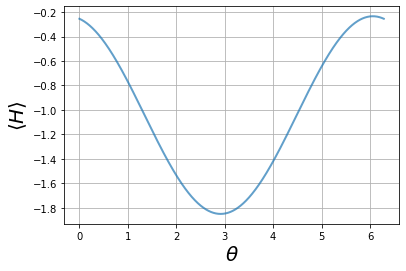

In [74]:
plt.plot(Theta_range, cost, linewidth= 2, alpha= 0.7)
plt.ylabel(r'$\langle H \rangle$', fontsize=20)
plt.xlabel(r'$\theta$', fontsize=20)
plt.grid('on')

# In the presence of dissipation, dephasing, ZZ interaction and leakage using non unitary propagators

In [14]:
import pickle
import numpy as np
import math
from qutip import*
import matplotlib.pyplot as plt
from qutip.qip.circuit import Gate
from qutip.qip.circuit import QubitCircuit, Gate
from qutip import tensor, basis
import itertools
pi=np.pi
import time

with open('Data\PauliX','rb') as read_file:
    PX = pickle.load(read_file)
    
with open('Data\PauliY','rb') as read_file:
    PY = pickle.load(read_file)
    
with open('Data\Idle','rb') as read_file:
    Idle = pickle.load(read_file)
    
with open('Data\CZ','rb') as read_file:
    CZ = pickle.load(read_file)
    
with open('Data\Hadamard','rb') as read_file:
    HD = pickle.load(read_file)
     
with open('Data\Angle','rb') as read_file:
    Angle = pickle.load(read_file)
    
with open('Data\Time','rb') as read_file:
    TimE = pickle.load(read_file)

In [15]:
class Add_gate:
    def __init__(gate, name, Tar_Con, angle):
        gate.name    = name
        gate.Tar_Con = Tar_Con
        gate.angle   = angle

In [16]:
# Time for Hadamard gate
Ang = pi/2
Diff = np.abs(Ang - Angle)
Index_Hada = np.where(np.min(Diff) == Diff)
Hada_time = TimE[Index_Hada]


Ang = pi
Diff = np.abs(Ang - Angle)
Index_Pauli = np.where(np.min(Diff) == Diff)
Pauli_time = TimE[Index_Pauli]

In [17]:
# Virtual PauliZ operator
def vPauliZ(theta):
    qc = QubitCircuit(N=1)
    qc.add_gate("RZ", targets=0, arg_value = theta)
    Z = qc.propagators()[0]
    
    Z3 = np.zeros((3,3), dtype = complex)
    Z3[0,0] = Z[0,0]
    Z3[0,1] = Z[0,1]
    Z3[1,0] = Z[1,0]   
    Z3[1,1] = Z[1,1]
    Z3[2,2] = 1
    return(to_super(Qobj(Z3)))

In [18]:
gate_time_Paulis = 2.00e-8
gate_time_CZ     = 2.71e-7

def Get_Unitaries(gate):
    
    unitaries = []
    for i in range(len(gate)):
        matrices = []
        gate_time_list = []
        
        for j in range(len(gate[i].name)):
            
            
            if gate[i].name[j] == 'PX': # Find the time for the Pauli gate 
                Ang = gate[i].angle[j]
                Diff_in_angle = np.abs(Ang - Angle)
                Index_angle = np.where(np.min(Diff_in_angle) == Diff_in_angle)[0][0]
                gate_time_list.append(TimE[Index_angle])
                
                
            elif gate[i].name[j] == 'PY': # Find the time for the Pauli gate 
                Ang = gate[i].angle[j]
                Diff_in_angle = np.abs(Ang - Angle)
                Index_angle = np.where(np.min(Diff_in_angle) == Diff_in_angle)[0][0]
                gate_time_list.append(TimE[Index_angle])
            
            
            elif gate[i].name[j] == 'PZ':
                gate_time_list.append(0)
                
            
            elif gate[i].name[j] == 'HD':
                gate_time_list.append(gate_time_Paulis/2)
                
                
            elif gate[i].name[j] == 'CZ':
                gate_time_list.append(gate_time_CZ)
                
            
            elif gate[i].name[j] == 'U':
                gate_time_list.append(0)
                
            
            else:
                print("GATE NOT FOUND IN THE LIST !! CHECK INPUTS")
          
        Max_gate_time = np.max(gate_time_list)         
        
        
        
        for k in range(len(gate[i].name)):
            
            if gate[i].name[k] == 'PX':
                angle_PX = gate[i].angle[k]
                if angle_PX<0:
                    angle_PX = math.radians(math.degrees(angle_PX) + 360)
                
                Lis= np.abs(Angle-angle_PX)
                Ind= np.where(Lis==np.min(Lis))
                res= PX[Ind]
                
                time_diff_for_idle= np.abs(TimE[Ind]-Max_gate_time)
                time_list= np.abs(TimE-time_diff_for_idle)
                Ind2= np.where(time_list==np.min(time_list))
                res= Idle[Ind2]*res   
                matrices.append(res[0])
                
                
                
            elif gate[i].name[k] == 'PY':
                angle_PY = gate[i].angle[k]
                if angle_PY<0:
                    angle_PY = math.radians(math.degrees(angle_PY) + 360) 
                if angle_PX>2*pi:
                    angle_PY = angle_PY%(2*pi)
                    
                Lis= np.abs(Angle-(angle_PY))
                Ind= np.where(Lis==np.min(Lis))
                res= PY[Ind]
                
                time_diff_for_idle= np.abs(TimE[Ind]-Max_gate_time)
                time_list= np.abs(TimE-time_diff_for_idle)
                Ind2= np.where(time_list==np.min(time_list))
                res= Idle[Ind2]*res      
                matrices.append(res[0])                
            
            
            
            elif gate[i].name[k] == 'PZ':
                angle_PZ = gate[i].angle[k]
                
                if angle_PZ<0:
                    angle_PZ = math.radians(math.degrees(angle_PZ) + 360)
                
                res = vPauliZ(angle_PZ)
                time_list= np.abs(TimE-Max_gate_time)
                Ind2= np.where(time_list==np.min(time_list))
                res= Idle[Ind2]*res      
                matrices.append(res[0])    
                
            
            
            elif gate[i].name[k] == 'HD':
                res = HD
                
                time_diff_for_idle= np.abs(TimE[Index_Hada]-Max_gate_time)
                time_list= np.abs(TimE-time_diff_for_idle)
                Ind2= np.where(time_list==np.min(time_list))
                res= Idle[Ind2]*res    
                matrices.append(res[0])   
                
                
                
            elif gate[i].name[k] == 'CZ':
                matrices.append(CZ)
  

                
            elif gate[i].name[k] == 'U':
                time_list= np.abs(TimE-Max_gate_time)
                Ind2= np.where(time_list==np.min(time_list))
                res = Idle[Ind2]
                matrices.append(res[0])
                
        unitaries.append(super_tensor(matrices))
                    
    return unitaries

In [19]:
Sz = Qobj(np.array(np.array([[1, 0, 0], [0, -1, 0], [0, 0, 1]])))
Sx = Qobj(np.array(np.array([[0, 1, 0], [1, 0, 0], [0, 0, 1]])))
Un = qeye(3)

# Calculating the cost function
H1= -1.0537076071291114*   tensor(Un,  Un)
H2=  0.3939836794385142*   tensor(Un,  Sz)
H3= -0.3939836794385142*   tensor(Sz,  Un)
H4= -0.011236585233181995* tensor(Sz,  Sz)
H5=  0.181288808211496*    tensor(Sx,  Sx)
cost_function= H1 + H2 + H3 + H4 + H5
initial_state= operator_to_vector(ket2dm(tensor(basis(3,0), basis(3,0))))

import time
theta_range= np.linspace(0,2*pi,1000)
start = time.time()  
cfunction=[]

for i, theta in enumerate(theta_range):
    gate=[]
    gate.append(Add_gate(name=["PX" , "HD"], Tar_Con=[1,2],   angle=[pi, 0]          ))
    gate.append(Add_gate(name=["PX" , "PZ"], Tar_Con=[1,2],   angle=[pi/2, theta]    ))
    gate.append(Add_gate(name=["U"  , "HD"], Tar_Con=[1,2],   angle=[]               ))
    gate.append(Add_gate(name=["CZ"       ], Tar_Con=[1,2],   angle=[]               ))
    gate.append(Add_gate(name=["PX" ,  "U"], Tar_Con=[1,2],   angle=[-pi/2, 0]       ))
      
    Unitaries= Get_Unitaries(gate)
    final_state= Unitaries[4]*Unitaries[3]*Unitaries[2]*Unitaries[1]*Unitaries[0]*initial_state
    final_state= vector_to_operator(final_state)
    cfunction.append(np.real(expect(final_state, cost_function)))
    if i%(len(theta_range)/5)==0:
        print((i/10), "% completed")
        
end = time.time()
print("----------------------------------------------------------------")
print("Total time elapased is", round(end-start,2), "seconds.")

0.0 % completed
20.0 % completed
40.0 % completed
60.0 % completed
80.0 % completed
----------------------------------------------------------------
Total time elapased is 7.3 seconds.


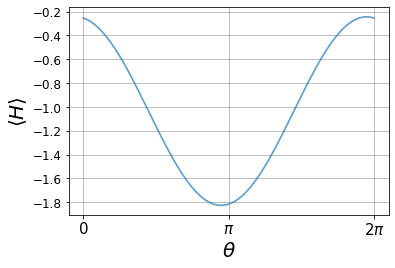

In [21]:
plt.plot(theta_range, cfunction, linewidth= 1.7, alpha= 0.7)
# plt.plot(theta_range, cost, '--', alpha= 0.7)
plt.ylabel(r'$\langle H \rangle$', fontsize=20)
plt.xlabel(r'$\theta$', fontsize=20)
plt.grid('on')
plt.xticks((0,pi,2*pi), ('0', '$\pi$', '$2\pi$'), fontsize=15)
plt.yticks(fontsize=12)
plt.subplots_adjust(left=0.16)
plt.subplots_adjust(bottom=0.16)
# plt.savefig('H2.pdf')

In [22]:
# print("Noisefree ground state energy is",  np.min(cost))
print("With noise ground state energy is", np.min(cfunction))

With noise ground state energy is -1.8266445279055763


In [9]:
import pickle
with open('Results\Cost_function_propagators', 'wb') as CF_propagators:
    pickle.dump(cfunction, CF_propagators)

In [84]:
import pickle
with open('Results\Cost_function_exact', 'wb') as CF_qutip:
    pickle.dump(cost, CF_qutip)

# This code calculates the ground state of $HeH_+$ molecule


In [10]:
import numpy as np
import math
from qutip import*
import matplotlib.pyplot as plt
from qutip.qip.circuit import Gate
from qutip.qip.circuit import QubitCircuit, Gate
from qutip import tensor, basis
import itertools
pi=np.pi
import time

# Noisefree circuit (QuTiP)


In [86]:
# Defining the cost function
H1= -3.1612743993611567*  tensor(qeye(2),  qeye(2))
H2=  0.559902866289939*   tensor(qeye(2),  sigmaz())
H3=  0.10643821234708065* tensor(qeye(2), sigmax())
H4= -0.559902866289939*   tensor(sigmaz(), qeye(2))
H5=  0.1064382123470806*  tensor(sigmax(), qeye(2))
H6= -0.09656999036547215* tensor(sigmaz(), sigmaz())
H7= -0.10643637985226966* tensor(sigmaz(), sigmax())
H8=  0.10643637985226964* tensor(sigmax(), sigmaz())
H9=  0.1437343068547859*  tensor(sigmax(), sigmax())

cost_function = H1 + H2 + H3 + H4 + H5 + H6 + H7 + H8 + H9


initial_state = tensor(basis(2,0), basis(2,0))

A_range= np.linspace(0,2*pi,100)
C_range= np.linspace(0,2*pi,101)
start = time.time()   
cost = []
state= []
for_plot_noisefree= np.zeros((100,101))

counter= 0
for i, A in enumerate(A_range):
    counter= counter + 1
    for j, C in enumerate(C_range):
        qc = QubitCircuit(2)
        qc.add_gate("RX",   targets=[0], arg_value= -pi/2)
        qc.add_gate("RX",   targets=[1], arg_value= pi/2)

        qc.add_gate("RZ",   targets=[0], arg_value= -A)
        qc.add_gate("RZ",   targets=[1], arg_value= A)

        qc.add_gate("RX",   targets=[1], arg_value= -pi/2)

        qc.add_gate("CZ",   controls= [0], targets=[1])

        qc.add_gate("SNOT", targets=[1])

        qc.add_gate("RZ",   targets=[1], arg_value= -C)

        qc.add_gate("SNOT", targets=[1])

        qc.add_gate("CZ",   controls= [0], targets=[1])

        qc.add_gate("RX",   targets=[0], arg_value= -pi/2)
        qc.add_gate("RX",   targets=[1], arg_value= pi/2)

        qc.add_gate("SNOT", targets=[0])
        qc.add_gate("SNOT", targets=[1])

        qc.add_gate("CZ",   controls= [0], targets=[1])

        qc.add_gate("SNOT", targets=[1])

        qc.add_gate("RZ",   targets=[1], arg_value= C)

        qc.add_gate("SNOT", targets=[1])

        qc.add_gate("CZ",   controls= [0], targets=[1])

        qc.add_gate("SNOT", targets=[0])
        qc.add_gate("SNOT", targets=[1])

        qc.add_gate("RX",   targets=[1], arg_value= -pi/2)

        final_state=(qc.run(state=initial_state))
        temp= expect(cost_function, final_state)
        cost.append(temp)
        for_plot_noisefree[i,j]= temp
        state.append(final_state)
    if counter%10==0:
        print(counter)

10
20
30
40
50
60
70
80
90
100


# In the presence of dissipation, dephasing, ZZ interaction and leakage using non unitary propagators

In [23]:
# Defining the cost function
Sz = Qobj(np.array(np.array([[1, 0, 0], [0, -1, 0], [0, 0, 1]])))
Sx = Qobj(np.array(np.array([[0, 1, 0], [1, 0, 0], [0, 0, 1]])))
Un = qeye(3)

H1= -3.1612743993611567*  tensor(Un, Un)
H2=  0.559902866289939*   tensor(Un, Sz)
H3=  0.10643821234708065* tensor(Un, Sx)
H4= -0.559902866289939*   tensor(Sz, Un)
H5=  0.1064382123470806*  tensor(Sx, Un)
H6= -0.09656999036547215* tensor(Sz, Sz)
H7= -0.10643637985226966* tensor(Sz, Sx)
H8=  0.10643637985226964* tensor(Sx, Sz)
H9=  0.1437343068547859*  tensor(Sx, Sx)

cost_function= H1 + H2 + H3 + H4 + H5 + H6 + H7 + H8 + H9
initial_state= operator_to_vector(ket2dm(tensor(basis(3,0), basis(3,0))))

start = time.time()   
cfunction = []

cfunction = []
for_plot_noise= np.zeros((100,101))
A_range= np.linspace(0,2*pi,100)
C_range= np.linspace(0,2*pi,101)

for i, A in enumerate(A_range):
    
    for j, C in enumerate(C_range):
        
        gate=[]
        gate.append(Add_gate(name=["PX" , "PX"], Tar_Con=[1,2],   angle=[-pi/2, pi/2]    ))
        gate.append(Add_gate(name=["PZ" , "PZ"], Tar_Con=[1,2],   angle=[-A, A]          ))
        gate.append(Add_gate(name=["U"  , "PX"], Tar_Con=[1,2],   angle=[0, -pi/2]       ))
        gate.append(Add_gate(name=["CZ"       ], Tar_Con=[1,2],   angle=[]               ))
        gate.append(Add_gate(name=["U"  , "HD"], Tar_Con=[1,2],   angle=[0, 0]           ))
        gate.append(Add_gate(name=["U"  , "PZ"], Tar_Con=[1,2],   angle=[0, -C]          ))
        gate.append(Add_gate(name=["U"  , "HD"], Tar_Con=[1,2],   angle=[0, 0]           ))
        gate.append(Add_gate(name=["CZ"       ], Tar_Con=[1,2],   angle=[]               ))
        gate.append(Add_gate(name=["PX" , "PX"], Tar_Con=[1,2],   angle=[-pi/2, pi/2]    ))
        gate.append(Add_gate(name=["HD" , "HD"], Tar_Con=[1,2],   angle=[0, 0]           ))
        gate.append(Add_gate(name=["CZ"       ], Tar_Con=[1,2],   angle=[]               ))
        gate.append(Add_gate(name=["U"  , "HD"], Tar_Con=[1,2],   angle=[0, 0]           ))
        gate.append(Add_gate(name=["U"  , "PZ"], Tar_Con=[1,2],   angle=[0, C]           ))
        gate.append(Add_gate(name=["U"  , "HD"], Tar_Con=[1,2],   angle=[0, 0]           ))
        gate.append(Add_gate(name=["CZ"       ], Tar_Con=[1,2],   angle=[]               ))
        gate.append(Add_gate(name=["HD" , "HD"], Tar_Con=[1,2],   angle=[0, 0]           ))
        gate.append(Add_gate(name=["U"  , "PX"], Tar_Con=[1,2],   angle=[0, -pi/2]       ))

        Unitaries= Get_Unitaries(gate)
        final_state= Unitaries[16]*Unitaries[15]*Unitaries[14]*Unitaries[13]* \
        Unitaries[12]*Unitaries[11]*Unitaries[10]*Unitaries[9]*Unitaries[8]* \
        Unitaries[7]*Unitaries[6]*Unitaries[5]*Unitaries[4]*Unitaries[3]* \
        Unitaries[2]*Unitaries[1]*Unitaries[0]*initial_state
        final_state= vector_to_operator(final_state)
        expectation= (np.real(expect(final_state, cost_function)))
        for_plot_noise[i,j]= expectation
        cfunction.append(expectation)
        
    per= int((i+1)/len(A_range)*100)
    if per%20==0:
        print(per, "% completed")
end = time.time()
print("Total time elapased is", round(end-start,2), "seconds.")

20 % completed
40 % completed
60 % completed
80 % completed
100 % completed
Total time elapased is 232.44 seconds.


In [25]:
# print("Noisefree ground state energy is", np.min(cost))
print("With noise ground state energy is",np.min(cfunction))

With noise ground state energy is -4.108300317683076


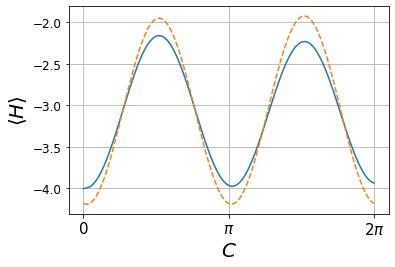

In [89]:
plt.plot(C_range, for_plot_noise[49,:])
plt.plot(C_range, for_plot_noisefree[49,:],'--')
plt.ylabel(r'$\langle H \rangle$', fontsize=20)
plt.xlabel(r'$C$', fontsize=20)
plt.grid('on')
plt.xticks((0,pi,2*pi), ('0', '$\pi$', '$2\pi$'), fontsize=15)
plt.yticks(fontsize=12)
plt.subplots_adjust(left=0.16)
plt.subplots_adjust(bottom=0.16)
plt.savefig('HeH+.pdf')

In [28]:
plt.pcolor(C_range, A_range, for_plot_noisefree,cmap='Greys', vmin= -4, vmax= -2, shading='auto')
plt.title('Noisefree', fontsize = 15)
plt.ylabel(r'$C$', fontsize=20)
plt.xlabel(r'$A$', fontsize=20)
plt.xticks((0,pi,2*pi), ('0', '$\pi$', '$2\pi$'), fontsize=15)
plt.yticks((0,pi,2*pi), ('0', '$\pi$', '$2\pi$'), fontsize=15)
plt.colorbar()

NameError: name 'for_plot_noisefree' is not defined

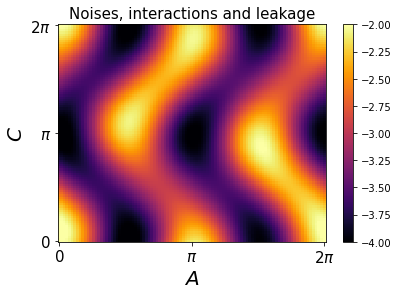

In [29]:
plt.pcolor(C_range, A_range, for_plot_noise,cmap='inferno', vmin= -4, vmax= -2, shading='auto')
plt.title('Noises, interactions and leakage', fontsize = 15)
plt.ylabel(r'$C$', fontsize=20)
plt.xlabel(r'$A$', fontsize=20)
plt.xticks((0,pi,2*pi), ('0', '$\pi$', '$2\pi$'), fontsize=15)
plt.yticks((0,pi,2*pi), ('0', '$\pi$', '$2\pi$'), fontsize=15)
plt.colorbar()

In [92]:
import pickle
with open('Results\Cost_function_QuTiP_HeHp', 'wb') as CF_qutip:
    pickle.dump(for_plot_noisefree, CF_qutip)


In [26]:
import pickle    
with open('Results\Cost_function_propagator_HeHp', 'wb') as CF_qutip:
    pickle.dump(for_plot_noise, CF_qutip)